# Predicting Default Loans 

## 1. INTRODUCTION
<a id="intro"></a>
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be deafult) and interpret the results to find the factors which affect the result. Such a predictive model could help investors make better-informed investment decisions.

We want to develop a model that can maximize **accuracy**(determine by f1-score and roc-auc-score), be easy to  **interpret** and minize **false negative** prediction.

This problem is a binary classification as we have only two classes to predict.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
import xgboost
from sklearn.preprocessing import RobustScaler

## 2. DATA

This dataset is provided as a coding challenge by one of the financial tech company in Chicago area.
The dataset contains around 80000 enteries and 25 different observations.
The target observation contains in the 'loan status' column. So we will take a look of the distribution of all the values in this column

In [3]:
#Using panda to read csv file into a dataframe
df = pd.read_csv('Data_(5).csv', index_col = 'id')
print(df.info())

#select loan_status column as our target variable and inspect the distribution of the values
print('Loan status distribution:')
print(df['loan_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 88787390 to 84114373
Data columns (total 25 columns):
loan_amnt                 80000 non-null int64
term                      80000 non-null object
installment               80000 non-null float64
emp_length                75131 non-null object
home_ownership            80000 non-null object
annual_inc                80000 non-null float64
verification_status       80000 non-null object
issue_d                   80000 non-null object
loan_status               80000 non-null object
purpose                   80000 non-null object
addr_state                80000 non-null object
dti                       80000 non-null float64
earliest_cr_line          80000 non-null object
fico_range_low            80000 non-null int64
fico_range_high           80000 non-null int64
last_credit_pull_d        79996 non-null object
last_fico_range_high      80000 non-null int64
last_fico_range_low       80000 non-null int64
acc_now_delinq     

### A) Determine right information for target value

The instances with 'Default' in the loan_status column will be considered as positive. 
Further, we can have several approaches with the data provided in the loan_status column to determine if the borrower does not default on a loan.
* First scenerio: If we decide that only 'Fully paid' borrowers are non-default borrowers, we will create a new dataframe that will consist of all columns with rows that only contain either ' Fully paid' or 'Default' on 'loan_status' feature. However, this approach will reduce dataframe from roughly 800000 rows to roughly 17000 rows. Over 60000 instances ('Current' on 'loan_status') were dropped from the dataset. 
* Second scenerio: Based on feature dictionary, 'Default' indicates absolute positive obervation (borrower default on loan). 'Fully Paid' indicates absolute negative observation (borrow definitely pays off loan). 'Current' indicate the borrower is in the progress of making payment for the loan; however, they can potentially default or make full payment. If we decide to treat 'Current' as borrowers who defintely will make full payment (equal to Fully Paid), we will have to take into consideration that 'Current' borrowers may still result into a default loan.

Because there is not enough information in the dataset to determine that borrowers with status of 'Current' will either default or not default on the loan, I choose the first scenerio since the dataset will have less noise. Plus, while losing approx. 60000 lines in the dataset, 17000 lines for the dataset can be enough for training the model. We can use also the 60000 droppped instances of dataset as a new test set of data when future information on the loan_status is collected. 

In [4]:
#new df with only fully paid and default loans
df = df.loc[df['loan_status'].isin(['Fully Paid','Default'])]
print('Dimension of the new dataframe: ')
print(df.shape)
print('Distribution of the total data:')
print(df['loan_status'].value_counts(normalize = True)) #66% of samples are fully paid and 34% of samples are default

Dimension of the new dataframe: 
(17571, 25)
Distribution of the total data:
Fully Paid    0.656423
Default       0.343577
Name: loan_status, dtype: float64


## 3. CLEANING DATA

In order to get the dataset ready for machine learning models, all categorical (dtype = object) need to be converted into numerical data. However, before performing transformation of data, unnecessary features and missing values will need to be processed and determine whether it is appropiate to remove these data.

In [5]:
#function to drop columns
def drop_cols(cols):
    df.drop(cols, axis =1, inplace = True)

### A) UNNECESSARY FEATURES:
The model is set to predict whether a new borrowers will pay off or default their loan before making the decision to lend the loan. 
* After inspecting the definition of each feature, 'last_fico_range_low','last_fico_range_high' and 'last_credit_pull_d' columns, whose information was collected after the loan decision has been made, are selected to remove in order to reduce noise of dataset

In [6]:
#drop columns contain after-loan features
after_loan_cols = ['last_fico_range_low','last_fico_range_high', 'last_credit_pull_d']
drop_cols(after_loan_cols)
print(df.shape)

(17571, 22)


Because the amount of default loans seems to be propotional to that of fully paid loans per each state, indicating that there is no bias on defaulting of a loan based on location of the borrower. I also decide to drop the 'addr_state' feature

In [7]:
#inspecting addr_state column
x = df['addr_state'].loc[df['loan_status'] == 'Default'].value_counts()
y = df['addr_state'].loc[df['loan_status'] == 'Fully Paid'].value_counts()
print(x.corr(y)) #0.98 correlation
#drop addr_state
drop_cols('addr_state')
print(df.shape)

0.9850426405018397
(17571, 21)


### B) MISSING VALUES

A function to determine missing value and a table summarized all missing values in each column are created. We noticed that there are 2 columns with more than 70% missing value. One column with 45% missing value and one column with approx 5% missing value. We will treat the missing values in these column differently

In [8]:
#function to determine columns with missing values
def miss_val(df):
    '''Determine number of percentage of missing values in a columnn'''
    #number of total missing value in the column
    miss_val = df.isnull().sum()
    #percent of total missing value
    miss_val_percent = 100*(df.isnull().sum())/len(df)
    #missing value type
    miss_val_type = df.dtypes
    #create a missing value table
    miss_val_table = pd.concat([miss_val, miss_val_percent, miss_val_type], axis =1).rename(columns= {0: 'total missing values', 1:'total % of missing value', 2: 'data type'})
    return miss_val_table
print('Missing Table')
display(miss_val(df))

Missing Table


,total missing values,total % of missing value,data type
loan_amnt,0,0.000000,int64
term,0,0.000000,object
installment,0,0.000000,float64
emp_length,1005,5.719652,object
home_ownership,0,0.000000,object
annual_inc,0,0.000000,float64
verification_status,0,0.000000,object
issue_d,0,0.000000,object
loan_status,0,0.000000,object
purpose,0,0.000000,object


For colunms with more than 70% of missing values (mths_since_last_record, inq_last_12m), I decide to remove these columns from the dataset

In [9]:
#select columns that have more than 50% of missing values to drop from dataframe
dropped_features_list = sorted(df.isnull().sum()[df.isnull().mean() > 0.5].index) 
#drop columns that have too many missing values (>50%)
drop_cols(dropped_features_list)
print(df.shape)

(17571, 19)


Although, column 'mths_since_last_delinq' contains almost 47% missing value, this feature can be important to determine loan default. We created a new column (delinq_before) contains all missing values of 'mths_since_last_delinq' converted to 0 - as no previous delinquency, and non-missing values converted to 1 - as have previous deliquency

In [10]:
#convert 'mths_since_last_delinq' column into 'delinq_before' with Yes: 1, No: 0
df['mths_since_last_delinq'].loc[df['mths_since_last_delinq'].notnull()] = 1
df['mths_since_last_delinq'].loc[df['mths_since_last_delinq'].isnull()] = 0
df['delinq_before'] = df['mths_since_last_delinq']
drop_cols('mths_since_last_delinq')
print(df.shape)

(17571, 19)


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


There are around 1000 NaN values (less than 5% of the total instances) in emp_length column. The distribution of the NaN value is not much different between default and fully paid loans. Thus, all NaN values can be removed in emp_length column.

In [11]:
#inspect NaN distribution in 'emp_length'
print('Distribution of NaN value in emp_length')
print(df.groupby('loan_status')['emp_length'].apply(lambda x: x.isnull().value_counts()))
'''the distribution of the NaN value is not much different between default and fully paid loan'''
#drop all NaN value in 'emp_length'
df = df.dropna(subset=['emp_length'])
print('Current shape of the dataframe:')
print(df.shape)

Distribution of NaN value in emp_length
loan_status       
Default      False     5621
             True       416
Fully Paid   False    10945
             True       589
Name: emp_length, dtype: int64
Current shape of the dataframe:
(16566, 19)


We also convert the entry of emp_length column from text into integer. By converting '10+ years' to '10 year' and '<1 year' to '0 year'. We then convert all of text into numeric values ranging from 0 to 10. 
After this process, the column is ready to be input in machine learning model.

In [12]:
#Convert emp_length data from object to numeric data based on description
#convert all 10+ years data to 10 years
df['emp_length'].replace('10+ years', '10 years', inplace = True)
#convert all '< 1 year' data to 0 year
df['emp_length'].replace('< 1 year', '0 year', inplace= True)
#convert all to numeric
df['emp_length'] = df['emp_length'].map(lambda x: float(str(x).split( )[0]))

#Convert term data from object to numeric data
df['term'] = df['term'].map(lambda y: float(str(y).split( )[0]))

#convert salary verification into numeric data. Verified/Source Verified (Yes):1 Not Verified (No): 0
df['salary_verified'] = df['verification_status'].apply(lambda x: np.float(np.logical_or(x == 'Verified', x=='Source Verified')))
drop_cols('verification_status')
print(df.shape)

(16566, 19)


### C. CREATE NEW FEATURES 
#### i. interest_rate feature:
* The 3 columns, 'loan_amnt', 'installment' and 'term', can be used to calculate interest_rate of a loan. Furthermore, these 3 features are also highly correlated with one another.
* A new feature called 'interest_rate' = 100% * ('term'*'installment'-'loan_amnt')/'loan_amnt'
* This feature turns out to be a good predictor for default borrower. Higher interest-rate borrowers tend to default loan more on average compared to lower interest-rate borrowers 
* 'loan-amnt' and 'term' columns are dropped to reduce noise of the dataset.

In [13]:
#Inspect correlation of loan_amnt, installment, and term
loan_cols = ['loan_amnt','installment', 'term']
print(df[loan_cols].corr())
#Because loan_amnt, installment and term can be used to calculate interest_rate of a loan, create new interest_rate feature
df['interest_rate']=100*(df['term']*df['installment']-df['loan_amnt'])/(df['loan_amnt'])
#Drop term and loan_amnt to prevent noise
drop_cols(['loan_amnt', 'term'])
print(df.shape)

             loan_amnt  installment      term
loan_amnt     1.000000     0.947910  0.406776
installment   0.947910     1.000000  0.152081
term          0.406776     0.152081  1.000000
(16566, 18)


#### ii. Credit_length feature: 
* Because the dataset provided information of on borrower's eariliest credit line, we can calculate an approx. credit length of the borrower by substracting year of earliest credit line ('earliest_cr_line') to the year of loan issuse date ('issue_d) and create a new credit_length column.
* Credit_length data also indicates that borrowers with longer credit length are less likely to default compared to borrowers with shorter credit length

In [14]:
#Convert both issue_d and earliest_cr_line to datetime and extract the year
df['issue_year'] = pd.to_datetime(df['issue_d'], format = '%m/%d/%Y').dt.year
df['earliest_cr_line_yr'] = pd.to_datetime(df['earliest_cr_line'], format = '%m/%d/%Y').dt.year
#Since credit length of the borrower may have affect on their risk to default or payoff loan
#Calculate credit length from earliest_cr_line_year and issue_year
df['credit_length'] = df['issue_year'] - df['earliest_cr_line_yr']
drop_cols(['issue_year', 'issue_d','earliest_cr_line_yr', 'earliest_cr_line'])

### iii. fico_score feature: 
* 'fico_range_low' and 'fico_range_high' are also highly linear. I decide to create an new column called fico_score which take the avarage of the two former columns
* fico_score also appears to be important to make prediction of default borrower, lower FICO score borrowers are more likely to default on loan.

In [15]:
#Because there are two FICO range score, I inspect correlation of fico_rang_low and fico_rang_high
fico_cols = ['fico_range_low','fico_range_high']
print(df[fico_cols].corr())
#These two value are highly correlated with each other. I will take a average of two and create a new col as fico_score
df['fico_score'] = (df['fico_range_low']+ df['fico_range_high'])/2
drop_cols(fico_cols)

                 fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0


In [16]:
#Inspect the shape of the dataframe
print('Current shape of the dataframe:')
print(df.shape)

Current shape of the dataframe:
(16566, 16)


## 3. EXPLORATORY DATA ANALYSIS

### A. Numeric Columns

I will perform EDA on all columns of the dataframe. Comparing the means of Default group and Fully-paid group using student t-test for numeric columns to determine if there is significant difference using p-value. Null Hypothesis: No difference between the means of two groups''
* While outliers can be determined by 25%tile, 75%tile,  I decide to keep all values to prevent further reduction of dataset. Outliers will later be dealt with in model using RobustScaler
* With assumption that all numeric features are nomally distributed, I calculated t-statistics and p-values of Student t-test to compare the means of the default group and fully paid group against null hypothesis that there is no significant difference between the two means.
* The Student's t-test indicates that for all features, there is significant difference between the means of two groups with p < 0.05 (95% CI)
* These analyses indicate that all of these features are important for our predictive model
* List of features: 'installment','interest_rate','emp_length','annual_inc','dti','fico_score','credit_length','acc_now_delinq','delinq_amnt','delinq_2yrs','inq_last_6mths'


In [17]:
#list of all numeric columns
numeric_cols = ['installment','interest_rate','emp_length','annual_inc','dti','fico_score','credit_length','acc_now_delinq','delinq_amnt','delinq_2yrs','inq_last_6mths']
#corvariance matrix of all numeric columns
print('COVARIANCE MATRIX OF ALL NUMERIC COLUMNS')
display(df[numeric_cols].cov())

COVARIANCE MATRIX OF ALL NUMERIC COLUMNS


,installment,interest_rate,emp_length,annual_inc,dti,fico_score,credit_length,acc_now_delinq,delinq_amnt,delinq_2yrs,inq_last_6mths
installment,6.983194e+04,1027.851694,55.981033,5.565984e+06,8.264000,494.925363,408.493494,0.174784,-1990.295193,-0.915837,4.295756
interest_rate,1.027852e+03,288.528167,0.629658,-2.077174e+04,29.124185,-113.544807,-16.151167,0.044524,243.746638,0.435330,2.140353
emp_length,5.598103e+01,0.629658,13.819096,1.831174e+04,0.651087,3.488058,9.247794,0.002225,-31.262632,0.046313,-0.027200
annual_inc,5.565984e+06,-20771.742531,18311.742470,1.052632e+10,-132882.431950,176598.637553,134444.596716,95.102889,110999.449816,1903.057777,2106.743021
dti,8.264000e+00,29.124185,0.651087,-1.328824e+05,77.473893,-23.277273,1.465873,0.001178,-51.697793,-0.221456,0.032258
fico_score,4.949254e+02,-113.544807,3.488058,1.765986e+05,-23.277273,966.375484,35.264395,-0.116740,-434.336377,-5.053598,-3.435622
credit_length,4.084935e+02,-16.151167,9.247794,1.344446e+05,1.465873,35.264395,175.831643,0.033284,142.248126,1.133130,0.030334
acc_now_delinq,1.747843e-01,0.044524,0.002225,9.510289e+01,0.001178,-0.116740,0.033284,0.007972,15.024952,0.010889,-0.001010
delinq_amnt,-1.990295e+03,243.746638,-31.262632,1.109994e+05,-51.697793,-434.336377,142.248126,15.024952,725876.794809,21.253906,0.505811
delinq_2yrs,-9.158366e-01,0.435330,0.046313,1.903058e+03,-0.221456,-5.053598,1.133130,0.010889,21.253906,0.952534,0.033319


In [18]:
#function to calculate t-test
def run_ttest(feature, col = 'loan_status', value1 = 'Fully Paid', value2 = 'Default'):
    '''Calculate t-statistics and p-value of t-test'''
    group1 = df.loc[df[col]== value1, feature]
    group2 = df.loc[df[col] == value2, feature]
    return ttest_ind(group1,group2)

#summary of all numeric features
for col in numeric_cols:
    print('\n Summary of '+ col)
    display(run_ttest(col))
    display(df.groupby('loan_status')[col].describe())


 Summary of installment


Ttest_indResult(statistic=-8.752947274540949, pvalue=2.2756554887415666e-18)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,480.670954,264.207735,31.88,287.06,416.84,631.23,1536.95
Fully Paid,10945.0,442.801715,263.372635,30.12,251.25,377.04,594.21,1464.42



 Summary of interest_rate


Ttest_indResult(statistic=-32.72373825284589, pvalue=1.1941423513993363e-227)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,35.137476,18.069450,8.41328,21.090500,29.376,49.083333,92.907692
Fully Paid,10945.0,26.297296,15.573487,8.41328,15.301829,21.345,31.146163,97.785714



 Summary of emp_length


Ttest_indResult(statistic=5.125245320353944, pvalue=3.004926167145822e-07)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,5.778687,3.735915,0.0,2.0,6.0,10.0,10.0
Fully Paid,10945.0,6.091092,3.703565,0.0,3.0,7.0,10.0,10.0



 Summary of annual_inc


Ttest_indResult(statistic=2.67224058387983, pvalue=0.007542035244354381)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,76180.658426,130313.884892,10000.0,45000.0,63000.0,88000.0,8706582.0
Fully Paid,10945.0,80678.742156,84884.774876,8160.0,50000.0,69100.0,96000.0,7000000.0



 Summary of dti


Ttest_indResult(statistic=-19.248617315387193, pvalue=1.1291045526087853e-81)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,20.761672,8.985511,0.0,14.06,20.59,27.41,63.98
Fully Paid,10945.0,18.012001,8.557944,0.0,11.56,17.43,23.86,51.73



 Summary of fico_score


Ttest_indResult(statistic=24.54273662394429, pvalue=1.1050483167030506e-130)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,687.185020,23.944284,662.0,667.0,682.0,697.0,842.0
Fully Paid,10945.0,699.483371,33.421212,662.0,672.0,692.0,717.0,847.5



 Summary of credit_length


Ttest_indResult(statistic=8.118347803916427, pvalue=5.055017963129322e-16)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,11.368440,13.087986,0.0,0.0,0.0,23.0,59.0
Fully Paid,10945.0,13.131476,13.308735,0.0,0.0,19.0,24.0,56.0



 Summary of acc_now_delinq


Ttest_indResult(statistic=-2.6812442465151434, pvalue=0.007342161781318559)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,0.010141,0.101958,0.0,0.0,0.0,0.0,2.0
Fully Paid,10945.0,0.006213,0.081994,0.0,0.0,0.0,0.0,2.0



 Summary of delinq_amnt


Ttest_indResult(statistic=-2.0416546441346455, pvalue=0.041201610288301015)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,37.133962,1274.844148,0.0,0.0,0.0,0.0,65000.0
Fully Paid,10945.0,8.593148,513.642896,0.0,0.0,0.0,0.0,42926.0



 Summary of delinq_2yrs


Ttest_indResult(statistic=-3.789976959376294, pvalue=0.0001511949512675743)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,0.397082,0.972551,0.0,0.0,0.0,0.0,14.0
Fully Paid,10945.0,0.336409,0.977139,0.0,0.0,0.0,0.0,39.0



 Summary of inq_last_6mths


Ttest_indResult(statistic=-8.273457297816396, pvalue=1.3992416437302393e-16)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Default,5621.0,0.762676,0.992266,0.0,0.0,0.0,1.0,5.0
Fully Paid,10945.0,0.634354,0.920083,0.0,0.0,0.0,1.0,6.0


### B. Binary value columns
For binary features, the summary describes the two propotion of Yes (1) or No (0) in each feature for the default and fully paid group. 
* Z-test is used test the null hypothesis that the two proportion are the same.
* Z-test shows that for both binary features, the p-values are smaller than 0.05, indicating that these features are also important for our predictive model.
* List of features: 'salary_verified', 'delinq_before'

In [19]:
#function to calculate z-test
def run_proportion_z_test(feature, col = 'loan_status', value1 = 'Fully Paid', value2 = 'Default'):
    '''Calculate z-statistics and p-value of z-test. Feature is the feature that z-test will be performed on'''
    group1 = df.loc[df[col]== value1, feature]
    group2 = df.loc[df[col] == value2, feature]
    n1 = len(group1)
    p1 = group1.sum()
    n2 = len(group2)
    p2 = group2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    return('z-score = {}; p-value = {}'.format(z_score, p_value))

In [20]:
#summary of binary feature
binary_cols = ['salary_verified', 'delinq_before']
for col in binary_cols:
    print('\n Summary of '+ col + ' (Yes:1, No: 0)')
    display(run_proportion_z_test(col))
    display(df.groupby('loan_status')[col].value_counts(normalize = True)) 


 Summary of salary_verified (Yes:1, No: 0)


'z-score = -11.624872890771325; p-value = 3.080515440030663e-31'

loan_status  salary_verified
Default      1.0                0.788650
             0.0                0.211350
Fully Paid   1.0                0.704249
             0.0                0.295751
Name: salary_verified, dtype: float64


 Summary of delinq_before (Yes:1, No: 0)


'z-score = -3.6793851367178614; p-value = 0.00023379696248935429'

loan_status  delinq_before
Default      1.0              0.549368
             0.0              0.450632
Fully Paid   1.0              0.519233
             0.0              0.480767
Name: delinq_before, dtype: float64

### C. Categorical features
For categorical features, the summary shows distribution of each category in the feature based on default or fully paid group
* chi square test is used to test either there is significant relationship between each categorical feature and the dependent variable
* p value (<0.05 95% CI) of chi square test indicated that there are significant relationship between the categorical feature and the dependent variable.
* These categorical variables will be used in our model. 
* List of features: 'purpose', 'home_ownership'

In [21]:
def run_chi2_test(feature, n, col = 'loan_status', value1 = 'Fully Paid', value2 = 'Default'):
    '''Calculate chi2 statistics and p-value. Feature is the feature that z-test will be performed on, n is number of categories'''
    group1 = df.loc[df[col] == value1,feature].value_counts().tolist()[:n] #select only the first 4 categories
    group2 = df.loc[df[col] == value2,feature].value_counts().tolist()[:n] #select only the first 4 categories
    chi2, p, dof, expected = chi2_contingency([group1, group2])
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [22]:
#inspect categorical column especially loan purpose and home_ownership
categorical_cols = ['purpose', 'home_ownership']
for category in categorical_cols:
    print('\n Summary of '+ category)
    if category == 'purpose':
        print(run_chi2_test (category, 12))
    else:  
        print(run_chi2_test (category, 4))
    print(df.groupby('loan_status')[category].value_counts(normalize = True))


 Summary of purpose
chi-square test statistic: 26.37854404975476
p-value 0.005698356658282462 

None
loan_status  purpose           
Default      debt_consolidation    0.636008
             credit_card           0.179150
             other                 0.057641
             home_improvement      0.052126
             major_purchase        0.020637
             small_business        0.014766
             medical               0.010852
             car                   0.007472
             moving                0.007116
             house                 0.006405
             vacation              0.006405
             renewable_energy      0.001423
Fully Paid   debt_consolidation    0.606122
             credit_card           0.195249
             home_improvement      0.066514
             other                 0.056921
             major_purchase        0.024212
             car                   0.010598
             medical               0.009868
             moving           

## 4. FEATURE ENGINEERING AND MODEL READY

a. Because both 'purpose' and 'home_ownership' columns are non-ordinal categorical columns, One-Hot Encoding technique is used to transform data of these columns into numeric values. I use get dummies feature in pandas package and choose to drop the first column for each of these dummy datasets.

b. The dependent variable (loan_status) is also converted into binary feature with 1 - indicating Default (positive instsance), and 0 - indicating Fully Paid (negative instance)

* The final dataframe should contain 28 features (columns) and 16566 observations (rows) including 66% negative instances (fully-paid) and 34% positive instances (default). We will have to take into account of the class imbalance of the dataset in our model building. 

In [23]:
#create dummies values for home_ownership and purpose features
df = pd.get_dummies(df, columns=['purpose', 'home_ownership'], drop_first = True)

#Convert loan_status column into numerical data. Fully_Paid : 0, Default: 1
df['default'] = df['loan_status'].apply(lambda x: np.float(x == 'Default'))
drop_cols('loan_status')

#inspect data frame that is ready for machine learning
print('FINAL DIMENSION OF DATAFRAME')
print(df.shape)
print('INSPECT FINAL DATAFRAME')
print(df.info())
print('Data distribution ')
print(df['default'].value_counts(normalize = True)) 
display(df.head(10))

FINAL DIMENSION OF DATAFRAME
(16566, 28)
INSPECT FINAL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16566 entries, 54027458 to 73611158
Data columns (total 28 columns):
installment                   16566 non-null float64
emp_length                    16566 non-null float64
annual_inc                    16566 non-null float64
dti                           16566 non-null float64
acc_now_delinq                16566 non-null int64
delinq_amnt                   16566 non-null int64
delinq_2yrs                   16566 non-null int64
inq_last_6mths                16566 non-null int64
delinq_before                 16566 non-null float64
salary_verified               16566 non-null float64
interest_rate                 16566 non-null float64
credit_length                 16566 non-null int64
fico_score                    16566 non-null float64
purpose_credit_card           16566 non-null uint8
purpose_debt_consolidation    16566 non-null uint8
purpose_home_improvement      16566

,installment,emp_length,annual_inc,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,inq_last_6mths,delinq_before,salary_verified,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_OWN,home_ownership_RENT,default
id,,,,,,,,,,,,,,,,,,,,,
54027458,439.88,5.0,50000.0,21.65,0,0,0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0.0
72594974,252.67,3.0,68000.0,29.09,0,0,0,2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
71061534,870.44,5.0,55000.0,13.35,0,0,0,1,0.0,1.0,...,0,0,1,0,0,0,0,0,1,0.0
54474095,382.55,5.0,30000.0,19.04,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0.0
45704513,677.85,10.0,84000.0,12.03,0,0,0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0.0
65261823,1182.33,0.0,90000.0,21.97,0,0,1,0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0.0
65686163,510.05,2.0,170000.0,18.21,0,0,0,1,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
51887109,212.43,1.0,91000.0,7.56,0,0,1,0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0.0
44017250,609.14,0.0,110000.0,32.89,0,0,1,0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


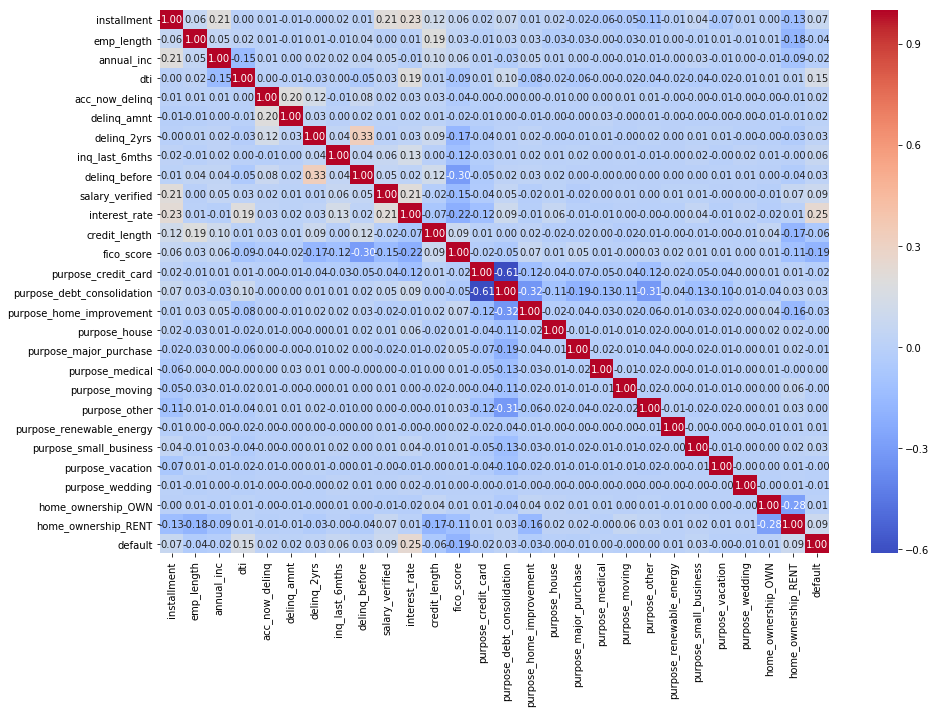

In [24]:
#heatmap shows pearson's correlation of all features with default
fig, ax = plt.subplots(figsize=(15,10)) 
cm_df = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)
plt.show()

## 5. MACHINE LEARNING
For this challenge, I will choose one of the Ensemble methods as machine leanring model for this dataset. Several options for Ensemble method such as Random Forest, Gradient Boosting or Adaptive Boosting can be used on the dataset.
* Ensemble method combined several base learners into the final model to reduce generalization error.
* Ensemble method relies on the fact that each base learner will look at different aspect of the dataset
* Ensemble method will always perform better than a single base learner model
* Combining multiple different models also reduces the correlation of each base learner, improve the performance of the ensemble model, and lead to outperform of the individual best model

Our final dataset contains approximately 66% negative examples and 34% positive examples.
* The class imbalance of this dataset can influence a learning algorithm during training by making the decision rule biased towards the majority class - implicitly train observation to make predictions based on the majority class. To reduce the effect of class imbalance in our dataset, we can use synthetic minority oversampling technique (SMOTE) to eliminate call imbalance.
* Because there are potentially outliers in each of the features, we can use several methods such as interquartile range to identify and remove these data. However, this approach further reduce our dataset. We will use a RobustScaler to standardize our dataset and reduce the influence of outliers.
* Last but not least, I will split the data into training set (70%), and test set (30%). Training set will be used to fit the model, and test set will be to evaluate the best model to get an estimation of generalization error. 
* We will use 5-folds cross validation through GridsearchSV to tune important hyperparameter of the model.

In [25]:
#select dependent and independent data
X = df.drop('default', axis = 1)
y = df['default']

#Scaling X features
X_transformed = RobustScaler().fit_transform(X)

#initiate SMOTE
smt = SMOTE (random_state = 42)
X_resampled, y_resampled = smt.fit_resample(X_transformed, y)
#checking whether resampling works
unique_elements, counts_elements = np.unique(y_resampled, return_counts=True)

#CREATE TRAIN AND TEST DATA SETS
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=.3, random_state=42)

Because the class imbalance in the dataset, accuracy of the model will not be a good measure to evaluate the model. Instead, I will use area under the ROC curve (AUC), log loss and f1-score to evaluate the model. 
* AUC is measuring the ability of the classifer to discriminate between positive and negative classes. The use of AUC will reduce the influence of class imbalance on model evaluation.
* f1 score takes into account the precision and recall to compute the score.

In [26]:
#function to evaluate model 
def evaluate_model(model, y_test, y_pred, y_prob):
    a,b,c,d = model, accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob), f1_score(y_test, y_pred, average='weighted')
    score_table = {'model': a, 'accuracy_score': b, 'auc_score': c, 'f1_score': d}
    df_score_table = pd.DataFrame(data = score_table, index = [1])
    print('---Score table for ' + model + '---')
    print(df_score_table)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('\n ---Confusion matrix for ' + model + '---')
    print({'tn':tn,'fp':fp,'fn':fn,'tp':tp})

Testing datasets with several classification models without tunining hyperparameters. We chose to use Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, Adaptive Boosting and Xtreme Gradient Boosting

In [27]:
#initiate models
lg = LogisticRegression(random_state = 42, solver = 'lbfgs')
tree = DecisionTreeClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42, n_estimators = 10)
gbc = GradientBoostingClassifier(random_state = 42)
abc = AdaBoostClassifier(random_state = 42)
xgb = XGBClassifier(objective="binary:logistic", random_state=42)

In [28]:
# fit model with logistic regression without tuning hyperparameters
lg.fit(X_train, y_train)
lg_y_pred = lg.predict(X_test)
lg_y_prob = lg.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Logistic Regression',y_test, lg_y_pred, lg_y_prob)


---Score table for Logistic Regression---
                 model  accuracy_score  auc_score  f1_score
1  Logistic Regression        0.640627   0.693733  0.640629

 ---Confusion matrix for Logistic Regression---
{'tn': 2099, 'fp': 1167, 'fn': 1193, 'tp': 2108}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [29]:
#fit model with decision tree without tuning hyperparameters 
tree.fit(X_train, y_train)
tree_y_pred = tree.predict(X_test)
tree_y_prob = tree.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Decision Tree',y_test, tree_y_pred, tree_y_prob)

---Score table for Decision Tree---
           model  accuracy_score  auc_score  f1_score
1  Decision Tree        0.654485   0.654487  0.654487

 ---Confusion matrix for Decision Tree---
{'tn': 2139, 'fp': 1127, 'fn': 1142, 'tp': 2159}


In [30]:
#fit model with Random forest classifier without  tuning hyperparameters
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_prob = rfc.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Random Forest Classifier',y_test, rfc_y_pred, rfc_y_prob)


---Score table for Random Forest Classifier---
                      model  accuracy_score  auc_score  f1_score
1  Random Forest Classifier        0.719354   0.790957  0.718436

 ---Confusion matrix for Random Forest Classifier---
{'tn': 2541, 'fp': 725, 'fn': 1118, 'tp': 2183}


In [31]:
#fit model with Gradient Boosting Classifier without tuning hyperparameters 
gbc.fit(X_train, y_train)
gbc_y_pred = gbc.predict(X_test)
gbc_y_prob = gbc.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Gradient Boosting Classifier',y_test, gbc_y_pred, gbc_y_prob)


---Score table for Gradient Boosting Classifier---
                          model  accuracy_score  auc_score  f1_score
1  Gradient Boosting Classifier        0.727425   0.810987  0.727423

 ---Confusion matrix for Gradient Boosting Classifier---
{'tn': 2393, 'fp': 873, 'fn': 917, 'tp': 2384}


In [32]:
#fit model with Adaptive Boosting Classifier without tuning hyperparameters 
abc.fit(X_train, y_train)
abc_y_pred = abc.predict(X_test)
abc_y_prob = abc.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Apdative Boosting Classifier',y_test, abc_y_pred, abc_y_prob)

---Score table for Apdative Boosting Classifier---
                          model  accuracy_score  auc_score  f1_score
1  Apdative Boosting Classifier        0.684331   0.751629  0.683788

 ---Confusion matrix for Apdative Boosting Classifier---
{'tn': 2102, 'fp': 1164, 'fn': 909, 'tp': 2392}


In [33]:
#fit model with XGB Classifier without tuning hyperparameters 
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
xgb_y_prob = xgb.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('XGB Classifier',y_test, xgb_y_pred, xgb_y_prob)


---Score table for XGB Classifier---
            model  accuracy_score  auc_score  f1_score
1  XGB Classifier        0.726359   0.811019  0.726344

 ---Confusion matrix for XGB Classifier---
{'tn': 2402, 'fp': 864, 'fn': 933, 'tp': 2368}


### 6. TUNING EXTREME GRADIENT BOOSTING CLASSIFIER

Our preliminary results showed that Xtreme Gradient Boosting can be a good candidate as the model for our dataset with high roc_auc_score and f1_score. 
* There are several hyperparameters that we will focus on tuning in this model
   - learning_rate
   - n_estimators: number of estimators
   - min_child_weight: the minimum sum of weights of all observations required in a child 
   - max_depth: the maximum number of terminal nodes or leaves in a tree.
   - gamma: a node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split
   - subsample: denotes the fraction of observations to be randomly samples for each tree
   - colsample_bytree:  denotes the fraction of columns to be randomly samples for each tree.

In [34]:
#tuning max_depth and min_child_weight
params_1 = {
    'max_depth' : [i for i in range (2,10,2)],
    'min_child_weight' : [i for i in range (2,10,2)]
}
gsearch1 = GridSearchCV(xgb, param_grid = params_1, cv =5, scoring = ['f1', 'roc_auc'], refit = 'f1')
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_) 
print(gsearch1.best_score_)  

{'max_depth': 8, 'min_child_weight': 6}
0.7336653186246491


In [35]:
#tuning gamma
params_2 = {
    'gamma' : [i/10 for i in range (0,5)]
}
gsearch2 = GridSearchCV(XGBClassifier(objective= 'binary:logistic', random_state = 42, max_depth = 8, min_child_weight =6), param_grid = params_2, cv =5, scoring = ['f1', 'roc_auc'], refit = 'f1')
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_) 
print(gsearch2.best_score_) 

{'gamma': 0.0}
0.7336653186246491


In [36]:
#tuning colsample_bytree and subsample
params_3 = {
    'colsample_bytree' : [i/100 for i in range (90,101,5)],
    'subsample' : [i/100 for i in range (85,101,5)]
}
gsearch3 = GridSearchCV(XGBClassifier(objective= 'binary:logistic', random_state = 42, max_depth = 8, 
                                      min_child_weight =6, gamma = 0), 
                        param_grid = params_3, cv =5, scoring = ['f1', 'roc_auc'], refit = 'f1')
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_) 
print(gsearch3.best_score_) 

{'colsample_bytree': 1.0, 'subsample': 1.0}
0.7336653186246491


In [37]:
#tuning learning rate
params_4 = {
    'learning_rate' : [i/100 for i in range (6,15,2)]
}
gsearch1 = GridSearchCV(XGBClassifier(objective= 'binary:logistic', random_state = 42, max_depth = 8, 
                                      min_child_weight =6, gamma = 0, colsample_bytree = 0.9, subsample = 0.85), 
                        param_grid = params_4, cv =5, scoring = ['f1', 'roc_auc'], refit = 'f1')
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_) 
print(gsearch1.best_score_) 

{'learning_rate': 0.06}
0.7352053418806419


In [104]:
#tuning n_estimators
params_5 = {
    'n_estimators' : [i for i in range(90,130,10)]
}
gsearch1 = GridSearchCV(XGBClassifier(objective= 'binary:logistic',  random_state = 42, learning_rate = 0.06, 
                                      max_depth = 8, min_child_weight =6, 
                                      gamma = 0, colsample_bytree = 0.9, subsample = 0.85), 
                        param_grid = params_5, cv =5, scoring = ['f1', 'roc_auc'], refit = 'f1')
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_) 
print(gsearch1.best_score_) 

{'n_estimators': 100}
0.7352053418806419


### 7. SCORE AND FEATURE IMPORTANCE
* Graphing of important features indicated that the top 7 important features are:
   - f10: 'interest_rate'
   - f12: 'fico_score'
   - f3: 'dti'
   - f0: 'installment'
   - f12: 'fico_score'
   - f2: 'annual_inc'
   - f1: 'emp_length'
   - f11: 'credit_length'

---Score table for Tuned XGB Classifier---
                  model  accuracy_score  auc_score  f1_score
1  Tuned XGB Classifier        0.749505   0.833027  0.748898

 ---Confusion matrix for Tuned XGB Classifier---
{'tn': 2614, 'fp': 652, 'fn': 993, 'tp': 2308}


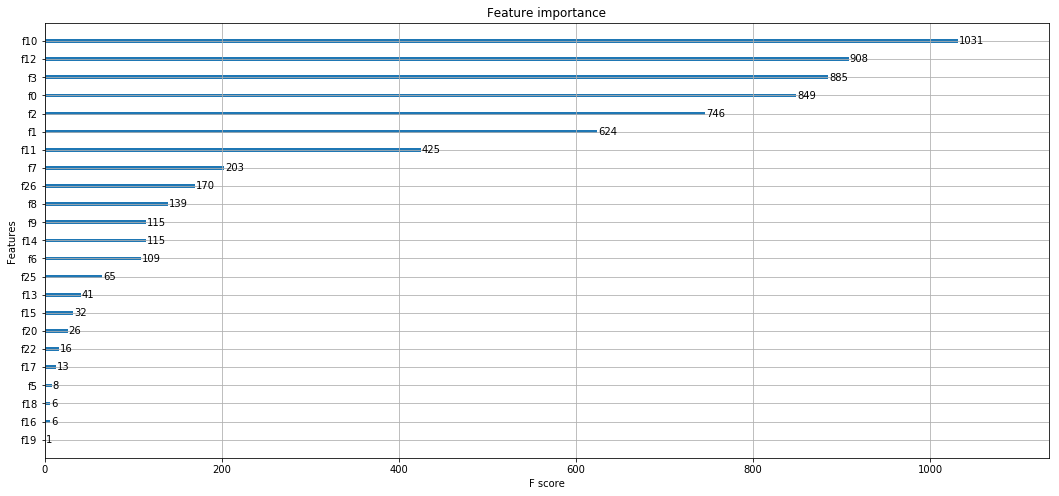

{'f0': 'installment', 'f1': 'emp_length', 'f2': 'annual_inc', 'f3': 'dti', 'f4': 'acc_now_delinq', 'f5': 'delinq_amnt', 'f6': 'delinq_2yrs', 'f7': 'inq_last_6mths', 'f8': 'delinq_before', 'f9': 'salary_verified', 'f10': 'interest_rate', 'f11': 'credit_length', 'f12': 'fico_score', 'f13': 'purpose_credit_card', 'f14': 'purpose_debt_consolidation', 'f15': 'purpose_home_improvement', 'f16': 'purpose_house', 'f17': 'purpose_major_purchase', 'f18': 'purpose_medical', 'f19': 'purpose_moving', 'f20': 'purpose_other', 'f21': 'purpose_renewable_energy', 'f22': 'purpose_small_business', 'f23': 'purpose_vacation', 'f24': 'purpose_wedding', 'f25': 'home_ownership_OWN', 'f26': 'home_ownership_RENT'}


In [131]:
#final tuned XGB classifier model
xgb_tuned = XGBClassifier(objective= 'binary:logistic',n_estimators= 100, random_state = 42, learning_rate = 0.06, 
                          max_depth = 8, min_child_weight =6, 
                          gamma = 0, colsample_bytree = 0.9, subsample = 0.85)
xgb_tuned.fit(X_train, y_train)
xgb_tuned_y_pred = xgb_tuned.predict(X_test)
xgb_tuned_y_prob = xgb_tuned.predict_proba(X_test)[:,1]
#show evaluation score
evaluate_model('Tuned XGB Classifier',y_test, xgb_tuned_y_pred, xgb_tuned_y_prob)
#Mapping important features with fscore 
feature_name = X.columns
f_list = xgboost.DMatrix(X_train, y_train).feature_names
d = dict(zip(f_list, feature_name)) 

#graphing important features
fig, ax = plt.subplots(figsize=(18,8))
plot_importance(xgb_tuned,ax = ax)
plt.show()
print(d)

### 8. ADJUSTING DECISION THRESHOLD

Eventhough our tuned model improved roc_auc_score and f1_score significantly and the model is easy to interpret with list of important features, this model does not reduce the amount of false negative (or default borrower but predicted as fully-paid by the model). One way to reduce false negative is to adjust the decision threshold. This below code shows how adjusting decision threshold will alter the amount of false negative in the prediction model, but also increase false positive.

While false negative is costly to the loan company, too many false positive can also decrease the maximum profits that a loan investor can get. Thus, we will need to make a decision to set an appropriate threshold for the model such that there is an appropiate ratio between false negative and false positive so that a loan investor can maximize its profit.

In [106]:
def adjusted_classes(y_scores, t):
    '''adjust the class based on the new threshold. Only work for binary classification'''
    return [1 if y >= t else 0 for y in y_scores]

In [107]:
# generate the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_tuned_y_prob)

In [134]:
def precision_recall_threshold_matrix(t):
    '''create confusion matrix for new adjusted threshold'''
    # generate new class predictions based on the adjusted_classes
    y_pred_adj = adjusted_classes(xgb_tuned_y_prob, t)
    print('Confusion matrix for threshold = ' + str(t))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
def precision_recall_threshold_curve(t):
    '''plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).'''
    y_pred_adj = adjusted_classes(xgb_tuned_y_prob, t)
    # plot the curve
    plt.figure(figsize=(5,5))
    plt.title("Precision and Recall curve at threshold = " + str(t))
    plt.step(recall, precision, color='r')
    plt.ylim([0.5, 1.0]);
    plt.xlim([0.5, 1.0]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], '^', c='k',
            markersize=10)

Confusion matrix for threshold = 0.1


,pred_neg,pred_pos
neg,244,3022
pos,15,3286


Confusion matrix for threshold = 0.15


,pred_neg,pred_pos
neg,490,2776
pos,48,3253


Confusion matrix for threshold = 0.2


,pred_neg,pred_pos
neg,761,2505
pos,109,3192


Confusion matrix for threshold = 0.25


,pred_neg,pred_pos
neg,1077,2189
pos,191,3110


Confusion matrix for threshold = 0.3


,pred_neg,pred_pos
neg,1400,1866
pos,297,3004


Confusion matrix for threshold = 0.35


,pred_neg,pred_pos
neg,1720,1546
pos,435,2866


Confusion matrix for threshold = 0.4


,pred_neg,pred_pos
neg,2038,1228
pos,597,2704


Confusion matrix for threshold = 0.45


,pred_neg,pred_pos
neg,2349,917
pos,796,2505


Confusion matrix for threshold = 0.5


,pred_neg,pred_pos
neg,2614,652
pos,993,2308


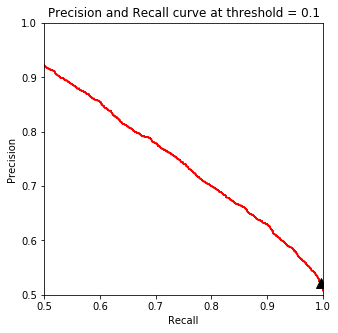

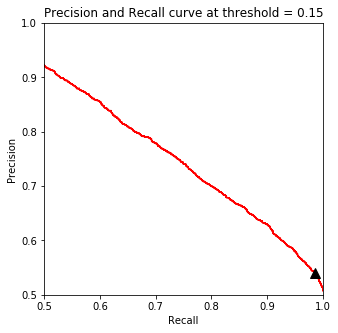

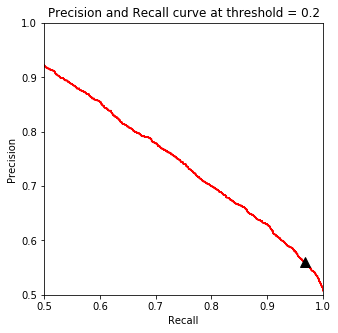

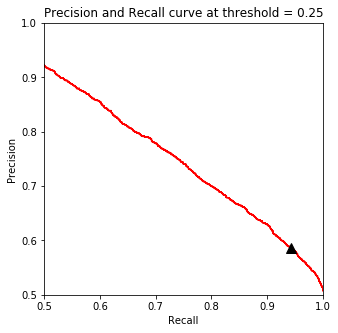

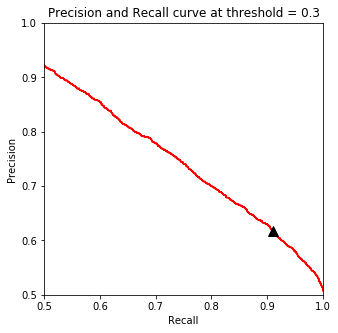

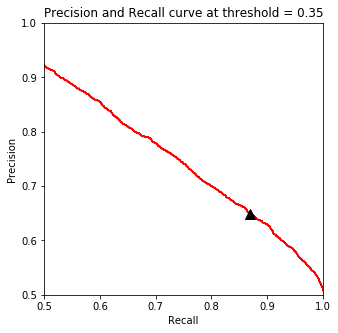

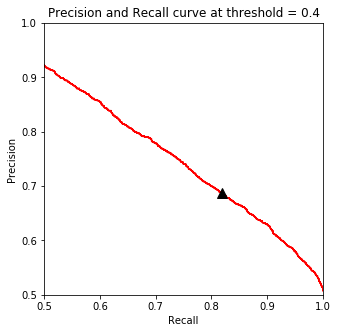

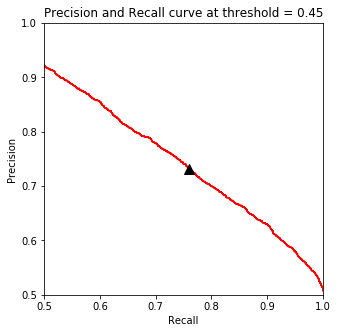

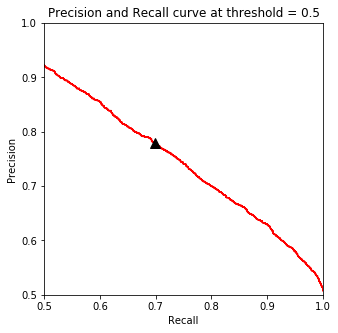

In [135]:
for i in [i/100 for i in range(10,51,5)]:
    precision_recall_threshold_matrix(i) 
    precision_recall_threshold_curve(i)